# How (Not) to Invest III - Beating the Market with Clenow Momentum
In the first two posts in this series, I wrote about the MACD, RSI, and Stochastic oscillator, all of which are momentum indicators. In this third post, I write about a less-known indicator: Clenow momentum. In his brilliant book *Stocks on the Move: Beating the Market with Hedge Fund Momentum Strategies*, Andreas Clenow outlines a framework for measuring momentum. His approach involves using an exponential regression to measure the direction and quality of trends. He combines these metrics into a ranking system for choosing the highest momentum stocks at any point in time, and proposes a volatility-based approach to portfolio optimisation.  
  
Although some claim that Clenow Momentum beat the market, in theory, any publicly available indicator should not. In this post, we evaluate the effectiveness of Clenow Momentum as a trading strategy.

# Clenow Momentum (CM)
  
## The Core: Exponential Regression
Typically, we would run a simple linear regression of prices on time to estimate how quickly a stock is growing over time. However, that would not be feasible for comparisons across stocks. Hence, Clenow proposes an *exponential* regression in which we run a regression of *log prices* on time. That relates time to *change* in price - and we know that percentage change makes sense for comparisons.  
  
Clenow proposes a rolling period of 90 days for the exponential regression. Given stock traders' abilities to rapidly react to new information, our measure of CM would need to be much more responsive. Hence, I propose a rolling period of 60 days instead.  
  
### Component 1: Coefficient of Exponential Regression
The first component of Clenow Momentum (CM) measures the trend. In a linear regression of log prices on time, the coefficient  on time essentially tells us the percentage increase in returns for a one-unit change in time (e.g. one day for daily data, 15 minutes for 15-minute data). Clearly, the larger the coefficient, the stronger the trend. To make the coefficient more intuitive, we *annualise* the coefficient.  
  
### Component 2: R-squared (R2) Measure of Exponential Regression
Second, Clenow proposes the R-squared (R2) of the exponential regression as a measure of the quality of the trend. Consider the two scenarios below:

In [1]:
# Import required modules
import fix_yahoo_finance as yf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import scipy.stats as ss
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import warnings
from yahoo_finance import Share

# Settings
warnings.filterwarnings('ignore')

# Override pdr
yf.pdr_override()

# Import stocklist
sp500 = pd.read_csv('sp500.csv')

In [3]:
# Create fake data: low R2
low_r2 = pd.DataFrame(
    {
        'a': [1,2,3,4,5],
        'b': [1,5,2,4,3]
    }
)

# Create fake data: high R2
high_r2 = pd.DataFrame(
    {
        'a': [1,2,3,4,5],
        'b': [1,3,2,3.5,3]
    }
)

a1,b1 = np.polyfit(low_r2.a, low_r2.b, 1)
a2,b2 = np.polyfit(high_r2.a, high_r2.b, 1)

# Calculate R2 for low R2 data
lm_lowr2 = LinearRegression()
lm_lowr2.fit(low_r2[['a']], low_r2.b)
r2_low = lm_lowr2.score(low_r2[['a']], low_r2.b)
coef_low = lm_lowr2.coef_[0]

# Calculate R2 for high R2 data
lm_hir2 = LinearRegression()
lm_hir2.fit(high_r2[['a']], high_r2.b)
r2_high = lm_hir2.score(high_r2[['a']], high_r2.b)
coef_high = lm_hir2.coef_[0]

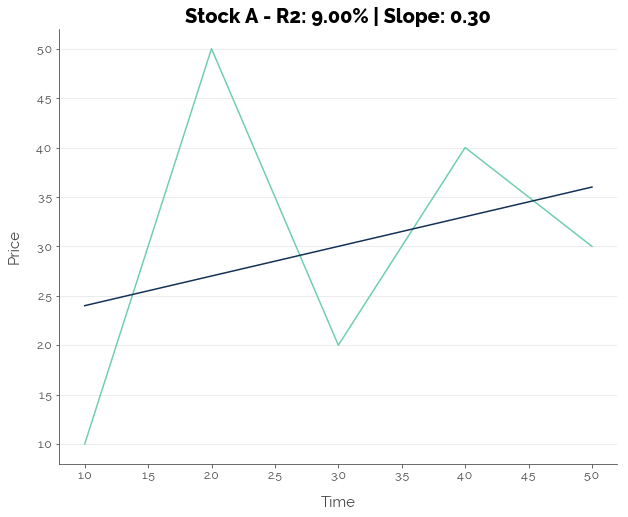

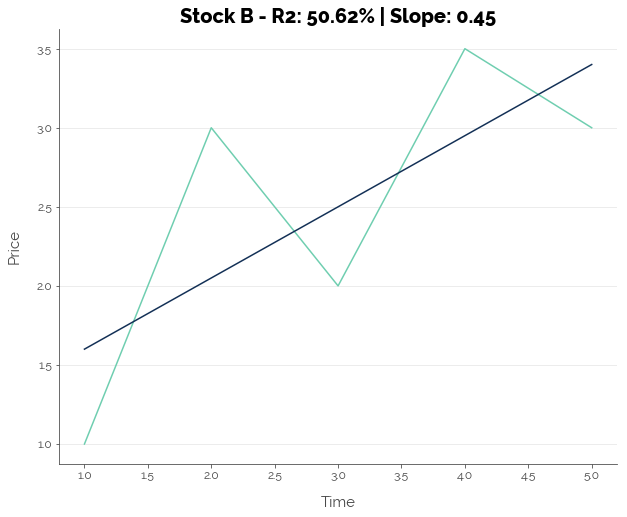

In [4]:
# CODE FOR GRAPHICS NOT INCLUDED

Assuming we have daily data, the slope is 0.30 for Stock A, which suggests that prices are increasing. However, the R2 is extremely low at **9.00%** due to volatility, especially on Day 2. For Stock B, the slope is even steeper, suggesting that prices are rising even faster than Stock A. It also has a lower R2. This means that the line was a much better fit to the data, due to the lower volatility of the stock price *around the general upward trend*. Thus, Clenow suggests that a stock that has a better R2 fit has a lower volatility, and has a higher probability of continuing its trend.

### Combined Component
Clenow posits that both the upward trend and goodness-of-fit are important. Hence, he combines both these measures by **multiplying them**:  
  
```
    Clenow Momentum (CM) = Annualised Slope of Regression Coefficient (%) * R2 of Regression (%)
```  

## Additional Conditions
Clenow slaps on two additional conditions for stock selection. We'll keep this in mind until we test a CM-based trading strategy.
  
1. **Never invest during a bear market.** The first of Clenow's (declared) additional conditions is to never invest when the market is declining. He does not believe in shorting stocks. Hence, he sets the rule that *if the S&P 500 is trading below its 200-day SMA, do not buy any stocks*.  
2. **The stock should be trending upward.** The second additional condition is that the stock should be trading above its 100-day SMA. This is used to quantitatively define an uptrend.  
3. **The stock price should be relatively stable.** The third of Clenow's additional conditions is that a stock should not have experienced a 15% or greater jump in price during the lookback period. Although this is implicitly captured under the goodness-of-fit (R2), Clenow implements this condition to ensure that prices are increasing gradually and not experiencing sudden jumps.  
  
## Stock Selection
Clenow proposes updating of portfolios on a weekly basis. On a fixed day each week, CM is calculated for a basket of stocks (the universe), and the stocks are ranked by their CM value. The greater the CM value, the higher the rank. Then, the portfolio is re-balanced. For now, the important thing to note is that the portfolio is updated **weekly** - this helps us to define the look-forward period for our tests: **5 days.**

# Testing Clenow Momentum I: Statistical Relationships
Clenow posits that the higher the CM score, the higher the probability of continued stock increases over the next 5 days. In this section, we test that assumption by computing the correlation between 5-day forward returns and CM, the R2 of exponential rolling-window regressions, and the slope coefficients of the regressions.  
  
In our computations, we use an adjusted version of CM (ACM), which incorporates the additional conditions stated above. In any time period where these conditions are not met, ACM is set to zero. ACM therefore represents a simplified version of Clenow's strategy.

In [5]:
# # Fix start date and end date
# start_date = '1979-01-01'
# end_date = '2018-06-01'

# # Pull data
# alldata = pdr.get_data_yahoo(list(sp500.Symbol), start_date, end_date, progress=False)

# # Pull S&P500 data
# sp500_index = pdr.get_data_yahoo('^GSPC', start_date, end_date, progress = False)

# # Save data
# sp500_index.to_csv('sp500_index.csv')

In [6]:
# # Save data
# alldata.to_csv('sp500_full.csv')
# alldata.Close.to_csv('sp500_close.csv')

### Function for Computing ACM Thresholds

In [7]:
def compute_acm(stk, lookback, full_df):
    
    # Pull data from main data frame
    stock_data = full_df[['days', 'sp500']].copy()
    stock_data['close'] = full_df[stk].copy()
    
    # Remove NaNs
    # stock_data.dropna(axis = 0, inplace = True)
    
    # Run rolling regression with 30-day windows
    temp_lm = pd.stats.ols.MovingOLS(
        y=np.log(stock_data.close), x=stock_data[['days']],
        window_type='rolling', window=lookback, intercept=True
    )
    
    # Compute Clenow Momentum
    stock_data['slope'] = ((temp_lm.beta.days + 1) ** 250 - 1) * 100
    stock_data['r2'] = temp_lm.r2 * 100
    stock_data['cm'] = stock_data.slope * stock_data.r2

    # Compute forward returns
    stock_data['ret'] = stock_data.close.shift(-5) / stock_data.close - 1

    # Compute F1: S&P500 trading above 200-day SMA
    stock_data['f1'] = (stock_data.sp500 >= pd.rolling_mean(stock_data.sp500, 200)).astype(int)

    # Compute F2: Stock is trading above 100-day SMA
    stock_data['f2'] = (stock_data.close >= pd.rolling_mean(stock_data.close, 100)).astype(int)

    # Compute F3: Stock has not gapped more than 15% within lookback period
    stock_data['roll_max'] = pd.rolling_max(stock_data.close, lookback)
    stock_data['roll_min'] = pd.rolling_min(stock_data.close, lookback)
    stock_data['inc'] = (stock_data.roll_max > stock_data.roll_min).astype(int)
    stock_data['max_gap'] = stock_data.inc * (stock_data.roll_max / stock_data.roll_min - 1) + \
        (stock_data.inc - 1) * (stock_data.roll_min / stock_data.roll_max - 1)
    stock_data['f3'] = (stock_data.max_gap < 0.15).astype(int)
    
    # Compute ACM
    stock_data['acm'] = stock_data.cm * stock_data.f1 * stock_data.f2 * stock_data.f3
    
    # Remove NaNs
    stock_data.dropna(axis = 0, inplace = True)
    
    # Calculate correlation between returns and ACM, R2, and slope
    corr_acm = stock_data[['ret', 'acm']].corr().iloc[0,1]
    corr_r2 = stock_data[['ret', 'r2']].corr().iloc[0,1]
    corr_slope = stock_data[['ret', 'slope']].corr().iloc[0,1]
    
    # Regression
    temp_lm = LinearRegression(n_jobs = 3)
    temp_lm.fit(stock_data[['acm', 'r2', 'slope']], stock_data.ret)
    
    # Extract coefficients
    coef_acm = temp_lm.coef_[0]
    coef_r2 = temp_lm.coef_[1]
    coef_slope = temp_lm.coef_[2]
    reg_r2 = temp_lm.score(stock_data[['acm', 'r2', 'slope']], stock_data.ret)
    
    # Configure output
    output = (corr_acm, corr_r2, corr_slope, reg_r2, coef_acm, coef_r2, coef_slope)
    
    # Output
    return output

In [8]:
# # Reload data
# alldata = pd.read_csv('sp500_close.csv')
# sp500_index = pd.read_csv('sp500_index.csv')

# # Add days
# alldata['days'] = np.arange(alldata.shape[0])

# # Add S&P500
# alldata['sp500'] = sp500_index.Close

# # Initialise results list
# all_pred = []

# # Configure parameters
# LOOKBACK = 60

# # Subset symbols
# symbol_subset = [x for x in list(sp500.Symbol) if x in list(alldata.columns)]

# # Loop through stocks
# for i in np.arange(0, len(symbol_subset)):
    
#     # Update
#     print('Computing statistics for ' + str(symbol_subset[i]) + ' ' + str(i) + ' of ' + str(len(symbol_subset)) + '...', end = '', flush = True)
    
#     # Compute thresholds
#     temp_thresh = compute_acm(symbol_subset[i], LOOKBACK, alldata)
    
#     # Append data
#     all_pred.append(temp_thresh)
    
#     # Print results
#     print('Done!')

In [9]:
# # Convert to data frame
# corr_data = pd.DataFrame(all_pred, columns = [
#     'corr_acm', 'corr_r2', 'corr_slope', 'reg_r2', 'coef_acm', 'coef_r2', 'coef_slope'
# ])

# # Save
# corr_data.to_csv('corr_data.csv', index = False)

From the graphs below, we see that on average, there was **no correlation between 5-day forward returns and ACM (which reflects the Clenow Momentum strategy) or the components of ACM: the regression R2 and slope**. The maximum size of the correlation coefficient in either direction (positive or negative) was at most 0.20, which is still relatively small.

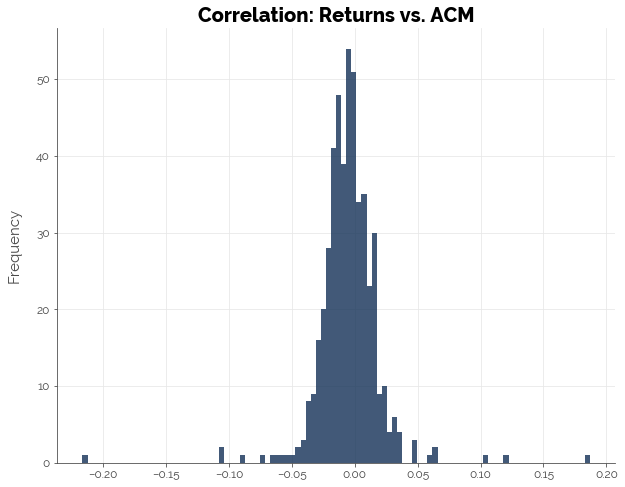

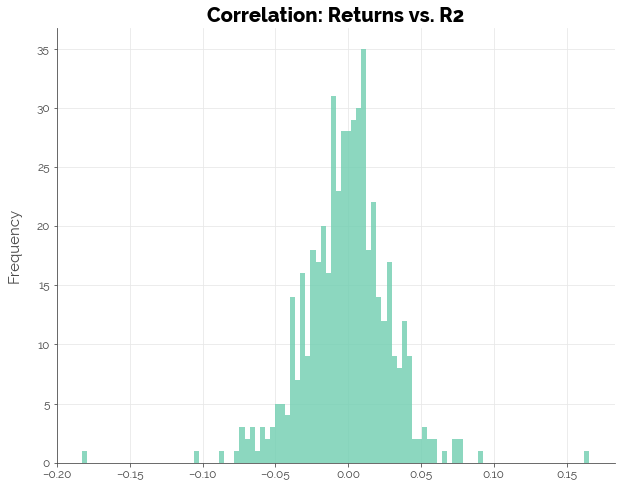

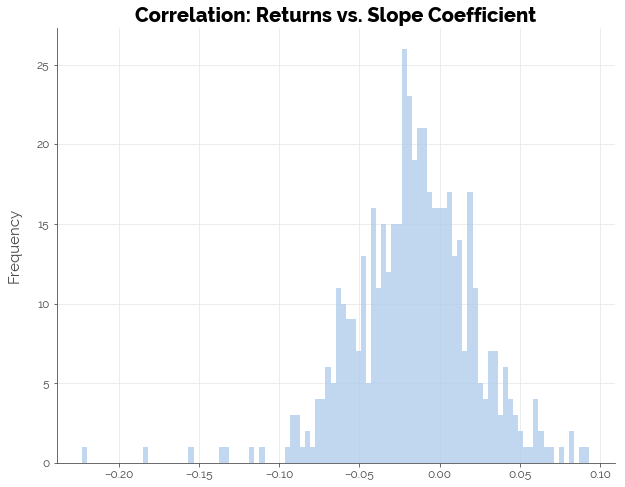

In [10]:
# CODE FOR GRAPHICS NOT INCLUDED

Thus, we may conclude that statistically, there is no strong relationship between ACM or its components with forward 5-day returns.

# Testing Clenow Momentum II: Trading Returns
We run a trading simulation using a simplified version of Clenow's approach to test if the strategy beats the buy-and-hold benchmark. The simplified strategy involves the following:  
  
1. Maintaining an equally-weighted portfolio that is reset every week
2. Choosing the top 10 stocks by ACM instead of the top *N* stocks by standard deviation up to a fixed amount in principal
  
Note that for the CM-based strategy, we only run one simulation because the approach applies to a universe of stocks (in this case the S&P 500). If we wanted confirmation on different universes of stocks, we could easily run the same simulation on the S&P Mid-Cap 400 or the Russell 1000.

### Function for Executing Trades

In [11]:
def trade_acm(stk, lookback, full_df):
    
    # Pull data from main data frame
    stock_data = full_df[['days', 'sp500']].copy()
    stock_data['close'] = full_df[stk].copy()
    
    # Run rolling regression with 30-day windows
    temp_lm = pd.stats.ols.MovingOLS(
        y=np.log(stock_data.close), x=stock_data[['days']],
        window_type='rolling', window=lookback, intercept=True
    )
    
    # Compute Clenow Momentum
    stock_data['slope'] = ((temp_lm.beta.days + 1) ** 250 - 1) * 100
    stock_data['r2'] = temp_lm.r2 * 100
    stock_data['cm'] = stock_data.slope * stock_data.r2

    # Compute forward returns
    stock_data['ret'] = stock_data.close.shift(-5) / stock_data.close - 1

    # Compute F1: S&P500 trading above 200-day SMA
    stock_data['f1'] = (stock_data.sp500 >= pd.rolling_mean(stock_data.sp500, 200)).astype(int)

    # Compute F2: Stock is trading above 100-day SMA
    stock_data['f2'] = (stock_data.close >= pd.rolling_mean(stock_data.close, 100)).astype(int)

    # Compute F3: Stock has not gapped more than 15% within lookback period
    stock_data['roll_max'] = pd.rolling_max(stock_data.close, lookback)
    stock_data['roll_min'] = pd.rolling_min(stock_data.close, lookback)
    stock_data['max_min'] = abs(pd.rolling_max(stock_data.close, lookback) / pd.rolling_min(stock_data.close, lookback)) - 1
    stock_data['min_max'] = abs(pd.rolling_min(stock_data.close, lookback) / pd.rolling_max(stock_data.close, lookback)) - 1
    stock_data['max_gap'] = stock_data[['max_min', 'min_max']].max(axis = 1)
    stock_data['f3'] = (abs(stock_data.max_gap) < 0.15).astype(int)
    
    # Compute ACM
    stock_data['acm'] = stock_data.cm * stock_data.f1 * stock_data.f2 * stock_data.f3
    
    # Output
    return (stock_data[['ret']], stock_data.acm)

In [12]:
# # Reload data
alldata = pd.read_csv('sp500_close.csv')
sp500_index = pd.read_csv('sp500_index.csv')

# # Add days
# alldata['days'] = np.arange(alldata.shape[0])

# # Add S&P500
# alldata['sp500'] = sp500_index.Close

# # Initialise results list
# all_ret = pd.DataFrame()
# all_acm = pd.DataFrame()

# # Configure parameters
# LOOKBACK = 60

# # Subset symbols
# symbol_subset = [x for x in list(sp500.Symbol) if x in list(alldata.columns)]

# # Loop through stocks
# for i in np.arange(0, len(symbol_subset)):
    
#     # Update
#     print('Computing ACM for ' + str(symbol_subset[i]) + ' - ' + str(i) + ' of ' + str(len(symbol_subset)) + '...', end = '', flush = True)
    
#     # Compute ACM
#     temp_acm = trade_acm(symbol_subset[i], LOOKBACK, alldata)
    
#     # Append data
#     all_ret[symbol_subset[i]] = temp_acm[0]
#     all_acm[symbol_subset[i]] = temp_acm[1]
    
#     # Print results
#     print('Done!')

### Compute Returns

In [13]:
# Save data
# all_ret.to_csv('ret_data.csv', index = False)
# all_acm.to_csv('acm_data.csv', index = False)

# Load data
all_ret = pd.read_csv('ret_data.csv')
all_acm = pd.read_csv('acm_data.csv')

# Truncate data by availability: at least 150 stocks to choose from
avail_acm = (~all_acm.isnull()).sum(axis = 1)
all_ret = all_ret.iloc[364:]
all_acm = all_acm.iloc[364:]

# Select data for every 5 days
all_ret = all_ret.iloc[::5,]
all_acm = all_acm.iloc[::5,]

# Replace NaNs with zeroes
all_acm[all_acm.isnull()] = 0

# Rank by row
rank_acm = all_acm.rank(axis = 1)

# Check for available rankings (at least 1 to 8)
rank_avail = rank_acm.apply(lambda x: (x <= 10).sum(), axis = 1) < 8

# Convert all rows with unavailable rankings to zero
rank_acm[rank_avail] = 0

# Convert all ranked stocks (1 to 10) to 1
rank_acm[(rank_acm > 0) & (rank_acm <= 10)] = 1

# Convert all values above 10 to zero
rank_acm[rank_acm > 10] = 0

# Get ranks available
n_stocks = rank_acm.sum(axis = 1)

# Convert zero values to 1
n_stocks[n_stocks == 0] = 1

# Divide returns by portfolio weight (equal) and add 1
all_ret = all_ret.divide(n_stocks, axis = 0)

# Convert missing values to zero
all_ret[all_ret.isnull()] = 0

# Multiply matrices
all_profits = all_ret * rank_acm

# Sum profits
all_profits['total'] = all_profits.sum(axis = 1) + 1

# Cumulative profits
all_profits['ctotal'] = np.cumprod(all_profits.total) * 100

# Add S&P 500
all_profits['sp500'] = sp500_index.iloc[364:,].Close[::5] / list(sp500_index.iloc[364:,].Close[::5])[0] * 100

# Add date
all_profits['Date'] = pd.to_datetime(sp500_index.iloc[364:,].Date[::5])

# Change index
all_profits.set_index('Date', inplace = True)

Overall, **the CM-based strategy beat the market**. There were periods where the strategy performed worse than the S&P 500, but the overall drawdowns were significantly lower.

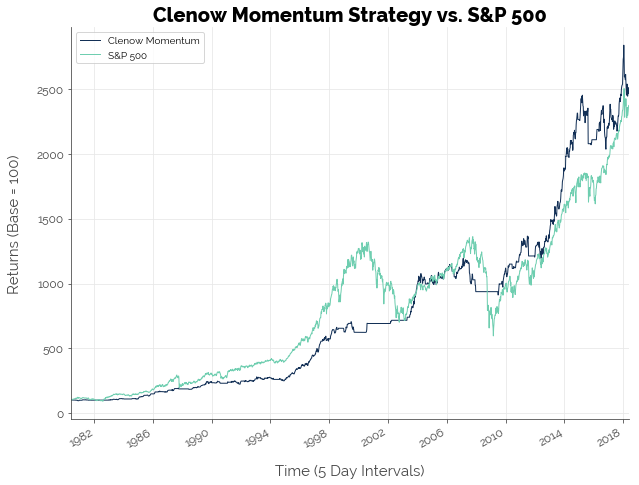

In [14]:
# CODE FOR GRAPHICS NOT INCLUDED

The performance of the CM-based strategy and the S&P 500 buy-and-hold benchmark are: (assuming a risk-free rate of 3.00%)

In [15]:
# Compute annualised returns
annret_cm = (all_profits.ctotal.iloc[-1] / 100) ** (50 / all_profits.shape[0]) - 1
annret_sp = (all_profits.sp500.iloc[-1] / all_profits.sp500.iloc[0]) ** (50 / all_profits.shape[0]) - 1

# Compute volatility
std_cm = (all_profits.total - 1).std() * np.sqrt(all_profits.shape[0] / 50)
std_sp = all_profits.sp500.pct_change().std() * np.sqrt(all_profits.shape[0] / 50)

# Compute max drawdown
maxdd_cm = np.min(all_profits.total - 1)
maxdd_sp = all_profits.sp500.pct_change().min()

# Configure table
sharpe_ratios = pd.DataFrame(
    [
        {'Strategy': 'CM',
         'Sharpe Ratio': (annret_cm - 0.03) / std_cm,
         'Returns': '{0:.2f}'.format(annret_cm * 100) + '%',
         'Volatility': '{0:.2f}'.format(std_cm * 100) + '%',
         'Max Drawdown': '{0:.2f}'.format(maxdd_cm * 100) + '%'},
        {'Strategy': 'Buy-and-Hold',
         'Sharpe Ratio': (annret_sp - 0.03) / std_sp,
         'Returns': '{0:.2f}'.format(annret_sp * 100) + '%',
         'Volatility': '{0:.2f}'.format(std_sp * 100) + '%',
         'Max Drawdown': '{0:.2f}'.format(maxdd_sp * 100) + '%'}
    ]
)

# Re-order and print
sharpe_ratios = sharpe_ratios[['Strategy', 'Returns', 'Volatility', 'Sharpe Ratio', 'Max Drawdown']]
sharpe_ratios

,Strategy,Returns,Volatility,Sharpe Ratio,Max Drawdown
0,CM,8.73%,8.45%,0.677899,-11.67%
1,Buy-and-Hold,8.62%,15.03%,0.373798,-27.33%


# How Did Clenow Momentum Beat the Market?!
Thus far, we found no statistically significant relationship between ACM and forward returns. However, we also found that Clenow's strategy beats the market! I propose two theories/potential reasons that explain these results.  
  
## 1. Momentum Works
Momentum is a sustained increase in price because demand outpaces supply. Hence, to make money from momentum, it makes sense to get in on the "demand side" as early as possible on a stock that other traders in the market will eventually buy. As long as demand continues to increase, returns for the early buyers will increase. Therefore, **momentum traders must buy stocks that other traders want, before the other traders want them**. This principal incentivises traders to make predictions on the next "hot stock", to monitor one another, and jump on the bandwagon as soon as a stock has shown some evidence of positive momentum. Therefore, **momentum works for traders who are able to identify stocks with momentum early enough**.  
  
This explanation may not have given credit to fundamental factors, but I recognise that fundamental analysis is equally important. The past financial crises have taught us that it is not enough for a stock to have price momentum; the company must have *value-creation momentum* as well. Only fundamental analysis can help us filter stocks that create value.  
  
## 2. Statistics Assumes a Single, Stable Underlying Relationship
In the trading simulation, note how the S&P 500 absolutely slayed the CM-based strategy. Only after the Dot-Com crash (first peak in the green graph) did the strategy start to match the S&P 500. Next, after the 2007 financial crisis, CM destroyed the S&P 500. I am not suggesting the strategy will become even more effective in the years to come. My point is that the relationship between indicators and stock prices change over time. Traditional indicators like MACD and RSI may have worked in the past, but don't work in the modern era. Newer indicators like CM failed in the past, but can now be used to beat the market.  
  
This phenomenon is related to investor psychology, which has been researched in depth by experts like [Robert Shiller](https://www.nytimes.com/2007/08/26/business/yourmoney/26view.html). On a broader level, stocks demonstrate how people think and survive. We observe how some practices translate to a reward, and we adapt. As more of us start to adapt, we crowd out the rewards. Some of us create new practices that are equally or more rewarding, and others adapt. This cycle causes old relationships (between practices and rewards) to break down, and new relationships to form. Consequently, there is no equilibrium; only efforts to strive toward one. We *invent* an equilibrium retrospectively (using past data) and *then* shape a narrative of it.  
  
In summary: relationships between indicators and stock prices are never the same...  
  
* In *different* time periods for the *same* stock
* In the *same* time period for *different* stocks
* In *different* time periods for *different* stocks
  
Consequently, traditional statistical tests (which assume some stable underlying relationship) will not be able to identify these relationships.

# Limitations
This study was limited in several ways. First, we employed a simplified version of Clenow's approach. We did not use Clenow's formula for portfolio re-balancing. Doing so would certainly have affected the portfolio weights. Second, we tested only one configuration: a lookback period of 60 days. Given that trading occurs at a faster pace, it may have been more appropriate to use a shorter lookback period and higher-resolution data. Third, we used only one set of data. I chose the S&P 500 as the universe of stocks that were input into the algorithm. Other more volatile indices like the S&P 400 would have produced different results. I also used daily returns for convenience. The strategy may or may not have been more effective on higher-resolution data. Although a more extensive study would be useful for validating Clenow's approach, the fact that it worked on the S&P 500 shows that it has massive potential.

# Conclusion [TLDR]
In this post, we showed that a strategy using Clenow Momentum **beat the S&P 500 buy-and-hold benchmark**, even though statistical tests showed no significant relation between 5-day forward returns and Clenow Momentum and it's individual components. I propose two explanations for this phenomenon: (1) momentum works and (2) relationships between indicators and stock returns change over time.  